# Lab session 3 : From textual data modelling to text classification

## Lecture 3 recap: Task specific Modelling of Textual Data 
1. Preprocessing textual data (word segmentation, encoding)
2. Modelling: 
  a. Sequence Labelling (MEMMs, CRF)  
  b. Sequence Classification   
3. Evaluation 

## Lab objective

In this session, we will focus on Sequence Classification.
We will classify tweets according to their sentiment mainly using Scikit-learn as our machine learning toolkit. To do so you will have to:

## 1. Preprocess the data
Adapt and combine the previous cleaning function (Lab session 2) with Scikit-learn Count Vectorizer or Tf-Idf Vectorizer for the text (X). 
Using the LabelBinarizer function for labels (Y).

## 2. Create training, dev, and test sets

## 3. Apply basic classifiers for multiclass classification: Support Vector Machines, Random Forest.

## 4. Create a function that gives a quantitative evaluation for a prediction: 
- precision
- recall
- f1-score: macro and weighted
- accuracy
- roc curve for each label

## 5. Compare prediction scores using previously trained embeddings (Lab session 2)

In [4]:
! wget -O tweets.csv https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv
! wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv

--2020-02-25 15:31:30--  https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/plain]
Saving to: ‘tweets.csv’

tweets.csv          100%[===================>]   3.26M  --.-KB/s    in 0.1s    

2020-02-25 15:31:31 (31.9 MB/s) - ‘tweets.csv’ saved [3421431/3421431]

--2020-02-25 15:31:32--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 13.226.113.83, 13.226.113.60, 13.226.113.39, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|13.226.113.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4309577 (4.1M)

In [0]:
import pandas as pd
dfTweets = pd.read_csv('tweets.csv')
df_pol = pd.read_csv('Political-media-DFE.csv', encoding='latin-1')

Re train pol embeddings (copied and pasted from lab session 2 correction) for later use

In [6]:
# Usage of Phrases and Phraser from gensim
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

from tqdm import tqdm
def tokenize_url_hashtags(corpus, tweets=False):
  if tweets:
    tokenizer = TweetTokenizer()
  else:
    tokenizer = TreebankWordTokenizer()  
    # Life hack : treebank word tokenizer won't keep html code in one token.
    # To preprocess economics news corpus, use tweettokenizer. 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = remove_url(tokens)
      tokens = remove_html(tokens)
      tokens = remove_hashtags(tokens)
      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences

cleaned_pol = tokenize_url_hashtags(df_pol.text.array, tweets=True)


from gensim.models.phrases import Phrases, Phraser

def clean_corpus(corpus, threshold=50, tweets=False):
  tokenized_sentences = tokenize_url_hashtags(corpus, tweets=tweets)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training 
  # samples
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus

from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

# We will just get the "WordVectors" parameter from the trained Word2Vec model.
# Otherwise, we could continue training with some more exemples that could be
# fed on the fly to the model.
print("Training the political W2V ...")
pol = Word2Vec(cleaned_pol, size=100, window=5, min_count=3, workers=cpu)
pol.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=10)
pol_wv = pol.wv

 12%|█▏        | 624/5000 [00:00<00:00, 6236.54it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 5000/5000 [00:01<00:00, 3544.47it/s]


The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the political W2V ...


Explore the dataset

In [7]:
dfTweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
print(dfTweets.text.iloc[0], dfTweets.airline_sentiment.iloc[0])

@VirginAmerica What @dhepburn said. neutral


In [9]:
dfTweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
dfTweets.shape

(14640, 15)

Here you can find some code for exploring the dataset using unsupervised learning (clustering) and visualization. A good clustering would require better tuned features.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import numpy as np

def tokens2vectors(tokenCorpus):
  ''' transforms our X into a list of list of vec (2D array) '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
      try: tweetVecs.append(pol_wv.get_vector(token)  )
      except: tweetVecs.append( np.zeros(100) ) 
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)

X = tokens2vectors(dfTweets.loc[:, "text"])

# X = dfTweets.loc[:, "text"]
# cv = CountVectorizer()
# X = cv.fit_transform(X)


In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20, max_iter=1000, verbose=0).fit(X)

In [0]:
clusters = kmeans.predict(X)

In [19]:
print(clusters[0], dfTweets["text"][0], dfTweets["airline_sentiment"][0])

print(clusters[1], dfTweets["text"][1], dfTweets["airline_sentiment"][1])

2 @VirginAmerica What @dhepburn said. neutral
2 @VirginAmerica plus you've added commercials to the experience... tacky. positive


In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate=100.0, early_exaggeration=2., n_iter=250)
X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14640 samples in 0.213s...
[t-SNE] Computed neighbors for 14640 samples in 66.777s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14640
[t-SNE] Computed conditional probabilities for sample 2000 / 14640
[t-SNE] Computed conditional probabilities for sample 3000 / 14640
[t-SNE] Computed conditional probabilities for sample 4000 / 14640
[t-SNE] Computed conditional probabilities for sample 5000 / 14640
[t-SNE] Computed conditional probabilities for sample 6000 / 14640
[t-SNE] Computed conditional probabilities for sample 7000 / 14640
[t-SNE] Computed conditional probabilities for sample 8000 / 14640
[t-SNE] Computed conditional probabilities for sample 9000 / 14640
[t-SNE] Computed conditional probabilities for sample 10000 / 14640
[t-SNE] Computed conditional probabilities for sample 11000 / 14640
[t-SNE] Computed conditional probabilities for sample 12000 / 14640
[t-SNE] Computed conditional probabilities for sa

In [22]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np


mapColors = {0:'lightseagreen', 1:'blueviolet', 2:'tomato'}
mapSentColors = {'positive':'lightseagreen', 'neutral':'blueviolet', 'negative':'tomato'}
colorsClusters = [mapColors[c] for c in clusters]
colorsSentiment = [mapSentColors[s] for s in dfTweets.airline_sentiment]

fig = go.Figure(data=go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    hovertext = list(zip(dfTweets.loc[:, "text"], dfTweets.airline_sentiment)),
    mode='markers+text',
    marker=dict(
        size=4,
        color=colorsClusters, # colorsClusters or colorsSentiment
        colorscale='Viridis',
        showscale=True,
    )
))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

# Sentiment Classification Test


To start the sentiment classification mockup, you need to check you data.

In [14]:
# prepare data for a basic classification
X = dfTweets.loc[:, "text"]
print(X)
print(X.shape)

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object
(14640,)


In [15]:
y = dfTweets.airline_sentiment
print(y)
print(y.shape)

0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14640, dtype: object
(14640,)


## Step 1: Adapt the cleaning function tokenize_url_hashtags for this corpus

We take our previous cleaning function and utils and apply it on this dataset. But in order to do so you need to slightly adapt it (we do not need sentences but whole tweets as String)

In [0]:
from tqdm import tqdm
def tokenize_url_hashtags_4tweets(corpus):
  ''' modified version for our data structure (flattened and only for tweets proc)'''
  tokenizer = TweetTokenizer() 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    ## we remove sentence split as we need to keep the whole tweet as one
    # # separating sentences
    # for sentence in sent_detector.tokenize(sample):
    tokens = tokenizer.tokenize(sample)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_hashtags(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_sentences.append(tokens)
  return tokenized_sentences

In [17]:
X = tokenize_url_hashtags_4tweets(dfTweets.text.array)
X = [' '.join(x) for x in X]
print(len(X), X[0])
print(len(dfTweets.text.array), dfTweets.text.array[0])


100%|██████████| 14640/14640 [00:01<00:00, 11710.88it/s]

14640 @virginamerica what @dhepburn said .
14640 @VirginAmerica What @dhepburn said.


## Step 2: Create Training set, Dev set and Test set


In a supervised classification task it is a good practice to slit the dataset into 3 sets:
- Training set: **60%**: used to train the classifier and obtain a model
- Dev set: **20%**: used to apply the model and check performance while tuning it
- Test set: **20%** used as the final performance check to see if the generalization is ok

Suggested convenient class: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split


In [19]:
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train)
print(y_train)


["@united why i won't check my carry on . watched a handler throw this bag - - miss the conveyer belt - - sat there 10 min", '@jetblue i knew the 3-4 hours sounded odd ; missed a flight we hit jfk an hour early for and your gate attendant told us 3-4 :(', '@americanair , check dm please !', '@jetblue 4 hr delay on flight to jfk via tampa & worst customer service in san juan airport . this after app not working all day .', 'all followers please note that @usairways is not taking customer service calls , nor responding by helping via soc . media dontflyusairways', '@americanair i really wanted to sign up for your airline credit card but your absurd $ 400 change fee to switch my flight made me think twice', '@united unfortunately still on the tarmac at @fly2ohare and definitely missing my ride from @flypdx gonnabealongnight', "@united ua1740 . as the inbound flight dep time gets closer you push it back 15 min . you've been doing this for 2 hrs .", '@americanair i have been waiting at this

In [20]:
# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)
print(X_dev)
print(y_dev)

['@southwestair another great flight & crew , las vegas-chicago 3397 . thanks !', '@virginamerica congrats on winning the @travelzoo award for best deals from an airline ( us )', '@usairways : i relied on us airways , and that was my mistake . awful customer experience .', "@united i'm desperately trying to understand how my girlfriend is being treated with this cancelled flightled / delayed flight . unacceptable ord", "@jetblue basically stole my glasses , and now i can't drive or see in my classes and they're not answering my phone calls . thanksjetblue", "@southwestair can't fly in precipitation and @delta has planes that don't work after 5 . 3rd airline had better be a charm tomorrow .", '@jetblue , your hold music sucks .', '@americanair how hard is it to have catering ready to go ?', '@virginamerica debbie baldwin gave a rockstar performance of the safety demo this evening on vx919 las2sfo bestcrew sherocks', "“ @jetblue : @analystdoc unfortunately that's not an available option 

## Preprocessing Text and Labels


We obtained our cleaned text in separate sets. Now we need to transform the text (the X sets) into vectors. Multiple approaches are available there. 
Start by using the CountVectorizer (bag of words and their occurrence counts in a sparse matrix).

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

Processing Text (X)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(8784, 10520)

In [22]:
# for dev set
X_dev_cv = cv.transform(X_dev)
X_dev_cv.shape

(2928, 10520)

You need to do the same for labels. A binarization is the way to go as we want a matrix representing each label. 

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

Processing Labels (y)

In [23]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

(8784, 3) (2928, 3)


## Basic Support Vector Machine


Now that we extracted very basic features from our tweets (bag of word), we need to apply a simple classifier to predict for each tweet if it is positive neutral or negative. This is a multiclass classification. 

You will use **Support Vector Machine** (SVM) for this but in a multiclass fashion (SVM separate data between two labels but we have three labels). For this we can apply a SVM for each label trying to find if it belongs to the target label or something else: this is a **One Versus Rest** approach. Please use the two links below (linearSVC is faster, hence best suited for this exercice)

The classifier should be trained on train set and apply on dev set.

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

Do not forget the main methods:

```python
.fit(X)
```

```python
.predict(y) # returns a list of predictions 
```



In [25]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
svm = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svm, n_jobs=1 ).fit(X_train_cv.toarray(), y_train_lb)

[LibLinear][LibLinear][LibLinear]

In [26]:
y_pred_svm = clf_svm.predict(X_dev_cv)
print(y_pred_svm.shape)

(2928, 3)


In [27]:
print(y_pred_svm[:5])
print(y_dev_lb[:5])

[[0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


## Create an eval function that accept y_true, y_pred, the label binarizer and the trained classifier as arguments.

It should display multiple quantitative evaluations:
- precision
- recall
- f1-score

*y_true* = the verified labels (from the dataset)
*y_pred* = the predicted labels (by the LinearSVC)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix


For the ROC curve you need to compute it separtely for each label *y* and then plot it using the mockup. 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve





In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['negative', 'neutral', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()


              precision    recall  f1-score   support

    negative       0.81      0.90      0.85      1855
     neutral       0.59      0.51      0.55       607
    positive       0.76      0.53      0.63       466

    accuracy                           0.76      2928
   macro avg       0.72      0.65      0.68      2928
weighted avg       0.75      0.76      0.75      2928



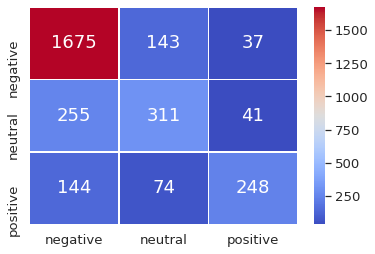

negative 0.7892743473094807
neutral 0.7142979329905944
positive 0.7770436819920299


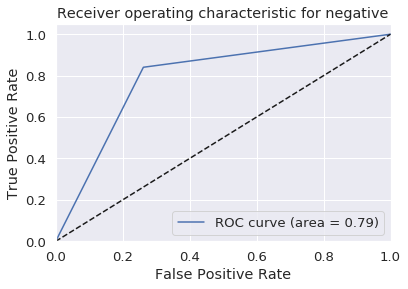

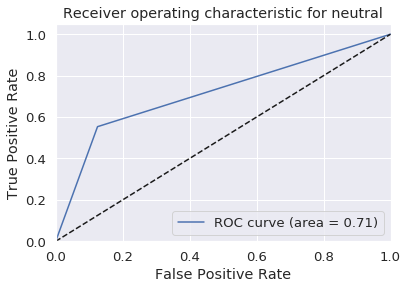

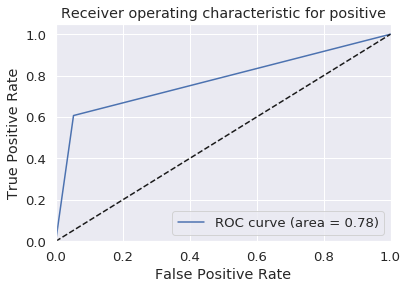

In [30]:
show_eval(y_dev_lb, y_pred_svm, lb_trained, clf_svm)

## Using Random Forest (Multiple decision trees)

Now apply the same task and logic but using **Random Forest** instead.

Please note that you do not need the **OneVSRestClassifier** class for this one.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Tips: 
- for faster computation reduce the number of trees in the forest (i.e. estimators)
```python
n_estimators=300
```
- use all available cores from the CPU:
```python
n_jobs=-1
```


In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
rfc.fit(X_train_cv, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.4s finished


              precision    recall  f1-score   support

    negative       0.72      0.98      0.83      1855
     neutral       0.70      0.27      0.39       607
    positive       0.89      0.33      0.48       466

    accuracy                           0.73      2928
   macro avg       0.77      0.52      0.57      2928
weighted avg       0.74      0.73      0.68      2928



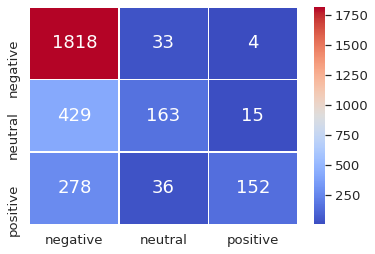

negative 0.7683375075047164
neutral 0.6194026036893999
positive 0.6592314772525215


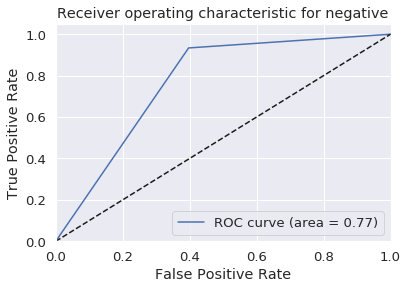

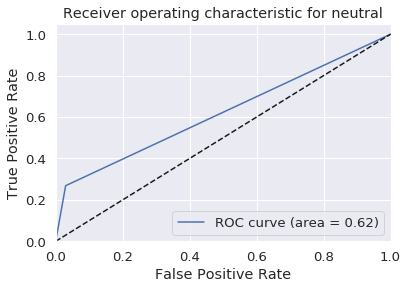

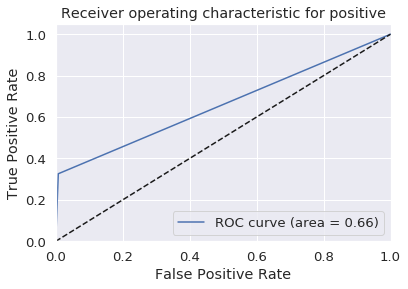

In [32]:
y_pred_rfc = rfc.predict(X_dev_cv)
show_eval(y_dev_lb, y_pred_rfc, lb_trained, rfc )

## Using pre-trained word embeddings

Apply the same task but using the embeddings vectors trained in the previous session and available in gensim model variable **pol_vw**. Use these embeddings as an input for **LinearSVC** and **Random Forest** classifiers.

Beware of the out of vocabulary words, find a way to handle them.

Remember we need a two dimensional array as a result:
(8784, 100)

In [33]:
# Create a function to transform the corpus into an embedding one
def tokens2vectors(tokenCorpus):
  ''' transforms our X into a list of list of vec (2D array) '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
      try: tweetVecs.append(pol_wv.get_vector(token)  )
      except: tweetVecs.append( np.zeros(100) ) 
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)


X_train_vec = tokens2vectors(X_train)
print(X_train_vec.shape, X_train_cv.shape)
# print(type(X_train_cv.toarray()), type(X_train_vec))
X_dev_vec = tokens2vectors(X_dev)
X_test_vec = tokens2vectors(X_test)


(8784, 100) (8784, 10520)


In [35]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
svm = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svm, n_jobs=1).fit(X_train_vec, y_train_lb)
y_pred_svm = clf_svm.predict(X_dev_vec)
print(y_pred_svm.shape)

[LibLinear][LibLinear][LibLinear](2928, 3)


              precision    recall  f1-score   support

    negative       0.69      0.98      0.81      1855
     neutral       0.63      0.12      0.20       607
    positive       0.80      0.30      0.44       466

    accuracy                           0.69      2928
   macro avg       0.71      0.47      0.48      2928
weighted avg       0.69      0.69      0.62      2928



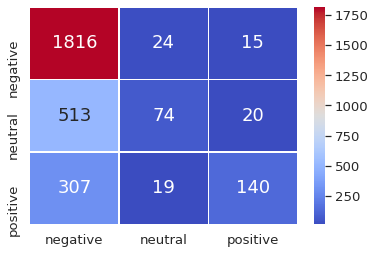

negative 0.6978414049331421
neutral 0.5660504653805559
positive 0.6439764244847868


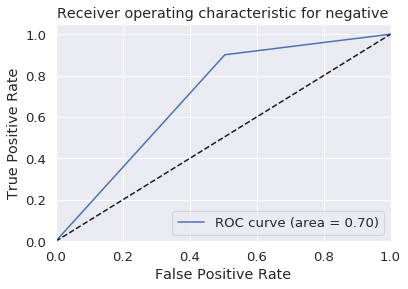

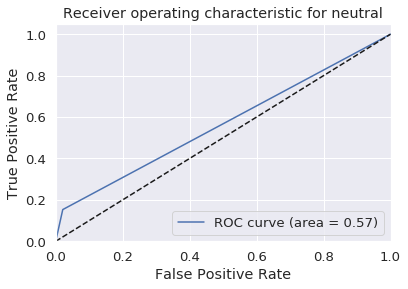

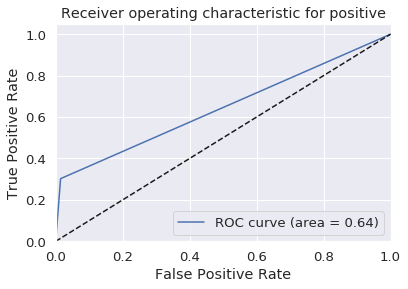

In [36]:
y_pred_svm = clf_svm.predict(X_dev_vec)
show_eval(y_dev_lb, y_pred_svm, lb_trained, svm )

In [37]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
rfc.fit(X_train_vec, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   34.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.3s finished


              precision    recall  f1-score   support

    negative       0.70      0.97      0.81      1855
     neutral       0.72      0.19      0.30       607
    positive       0.78      0.30      0.43       466

    accuracy                           0.70      2928
   macro avg       0.73      0.49      0.51      2928
weighted avg       0.71      0.70      0.64      2928



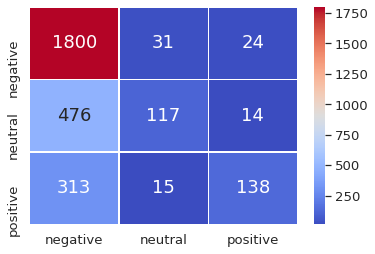

negative 0.6900337366830536
neutral 0.5864660960345588
positive 0.6403513665222105


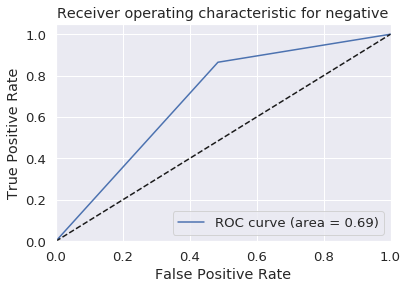

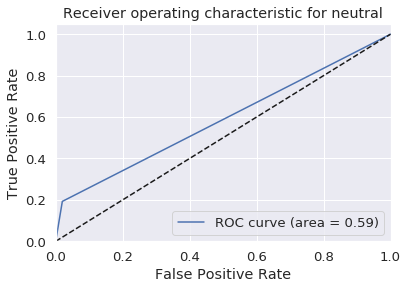

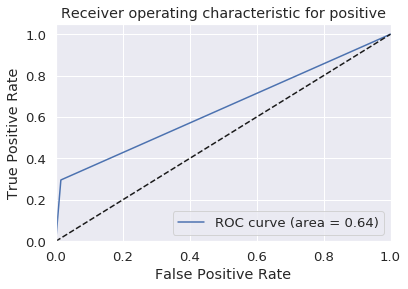

In [38]:
y_pred_rfc = rfc.predict(X_dev_vec)
show_eval(y_dev_lb, y_pred_rfc, lb_trained, rfc )